# Modèle de chute verticale

## Présentation

On considère une masse soumise, dans un fluide visqueux, à une vitesse initiale verticale. Cette masse est freinée par l’air, qui s’oppose à l’avancement de la masse. On fait l’hypothèse que cette trainée est linéaire en fonction de la vitesse.

L’équation différentielle qui modélise le problème est :

$$
m \frac{dv}{dt} = -m g - cv
$$
où 
- $v$ est la vitesse verticale (m/s), 
- $m$ est la masse (kg), 
- $g$ est le coefficient d’accélération de la gravité (m/s2),
- $c$ est le coefficient de traînée linéaire (kg/s).

Une vitesse positive est considérée en direction du haut.

Il s’avère que, lorsque la traînée est visqueuse, cette équation différentielle possède une solution explicite en fonction du temps. Ce n’est pas le cas lorsqu’on considère une force de frottement quadratique, par exemple pour modéliser le frottement dans l’air. 

On peut démontrer que l’altitude z de la masse en fonction du temps t est
$$
z(t) = z_0 + v_{inf} t+ \tau (v_0-v_{inf})(1-exp(-t/\tau))
$$
pour $t$ dans $[0,tmax]$, où
- $z$ est l’altitude (m) au dessus de la surface de la Terre,
- $z_0$ est l’altitude initiale (m),
- $v_0$ est la vitesse initiale (m/s),
- $t$ est le temps (s),
- $v_{inf} = -mg/c$ est la vitesse limite (m/s),
- $\tau = m/c$ est la caractéristique de temps (s).

On considère que l’altitude reste supérieure à un seuil donné, par exemple z=0. En conséquence, la trajectoire de l’altitude devient singulière dès qu’elle atteint ce seuil.
$$
y(t) = \max(z(t),0)
$$
pour $t$ dans $[0,tmax]$.

On considère les valeurs suivantes :
$$
g = 9.81 \textrm{ (m/s2)}, \quad z0 = 100 \textrm{ (m)}, \quad 
v0 = 55 \textrm{ (m/s)}, \quad m = 80 \textrm{ (kg)}, \quad 
c = 15 \textrm{ (kg/s)}, \quad tmax = 12 \textrm{ (s)}.
$$

Lorsqu’il n’y a pas de frottement, i.e. lorsque c=0, on peut obtenir une expression encore plus simple de l’altitude :
$$
z(t) = z_0 + v_0 t  - g t^2
$$
pour $t$ dans $[0,tmax]$.

<img src="trajectoire-vs-coefficient.png" width="400">

## Incertitudes

Lorsqu’on probabilise les variables $z_0$, $v_0$, $m$ et $c$, les trajectoires constituent un processus stochastique. On considère des variables aléatoires uniformes et gaussiennes, supposées indépendantes.

|Variable|  Distribution|
| ------------- |-------------|
| $z_0$ |  Uniform(100.,150.) |
| $v_0$ | Normal(55.,10.) |
| $m$ | Normal(80.,8.) |
| $c$ | Uniform(0.,30.) |

## Références

Steven C. Chapra. Applied numerical methods with Matlab for engineers and scientists, third edition. 2012.

In [1]:
import openturns as ot
import numpy as np

In [2]:
tmin=0. # Date minimale
tmax=12. # Date maximale
gridsize=100 # Nombre de pas de temps
mesh = ot.IntervalMesher([gridsize-1]).build(ot.Interval(tmin, tmax))

In [3]:
def AltiFunc(X):
    g  = 9.81
    z0 = X[0]
    v0 = X[1]
    m  = X[2]
    c  = X[3]
    zmin = 0.
    tau=m/c
    vinf=-m*g/c
    t = np.linspace(tmin,tmax,gridsize)
    z=z0+vinf*t+tau*(v0-vinf)*(1-np.exp(-t/tau))
    z=np.maximum(z,zmin)
    altitude = [[zeta] for zeta in z]
    return altitude

In [4]:
inputDim = 4
outputDim = 1
alti = ot.PythonPointToFieldFunction(inputDim, mesh, outputDim, AltiFunc)

In [5]:
# Creation of the input distribution
distZ0 = ot.Uniform(100.0, 150.0)
distV0 = ot.Normal(55.0, 10.0)
distM = ot.Normal(80.0, 8.0)
distC = ot.Uniform(0.0, 30.0)
distX = ot.ComposedDistribution([distZ0, distV0, distM, distC])

In [6]:
# Sample the model
size = 10
inputSample = distX.getSample(size)
outputSample = alti(inputSample)

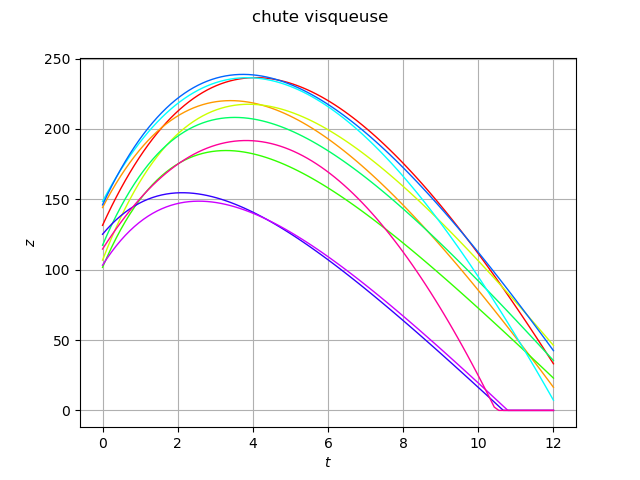

In [7]:
# Draw some curves
graph = outputSample.drawMarginal(0)
graph.setTitle('chute visqueuse')
graph.setXTitle(r'$t$')
graph.setYTitle(r'$z$')
graph.setColors([ot.Drawable.ConvertFromHSV(i * (360.0/size), 1.0, 1.0) for i in range(len(graph.getDrawables()))])
graph

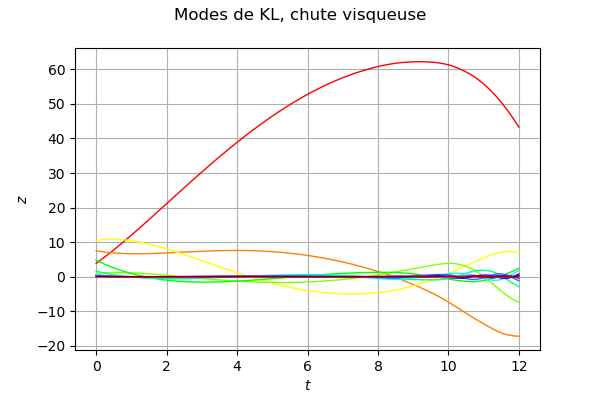

In [8]:
# Compute the KL decomposition of the output
size = 500
inputSample = distX.getSample(size)
outputSample = alti(inputSample)
algo = ot.KarhunenLoeveSVDAlgorithm(outputSample, 1.0e-6)
algo.run()
KLResult = algo.getResult()
scaledModes = KLResult.getScaledModesAsProcessSample()
graph = scaledModes.drawMarginal(0)
graph.setTitle('Modes de KL, chute visqueuse')
graph.setXTitle(r'$t$')
graph.setYTitle(r'$z$')
graph

In [9]:
postProcessing = ot.KarhunenLoeveLifting(KLResult)
outputSampleChaos = KLResult.project(outputSample)

Puis on créée un métamodèle de chaos polynomial.

In [10]:
univariatePolynomials = [ot.StandardDistributionPolynomialFactory(distX.getMarginal(i)) for i in range(inputDim)]
basis = ot.OrthogonalProductPolynomialFactory(univariatePolynomials)
maximumDegree = 3
enumfunc = ot.EnumerateFunction(inputDim).getStrataCumulatedCardinal(maximumDegree)
truncationStrategy = ot.FixedStrategy(basis, enumfunc)
fittingAlgorithm = ot.CorrectedLeaveOneOut()
modelSelection = ot.LeastSquaresMetaModelSelectionFactory(ot.LARS(), fittingAlgorithm)
projectionStrategy = ot.LeastSquaresStrategy(modelSelection)
algo = ot.FunctionalChaosAlgorithm(inputSample, outputSampleChaos, distX, truncationStrategy, projectionStrategy)
algo.run()
reducedPCmetamodel = algo.getResult().getMetaModel()
metaModel = ot.PointToFieldConnection(postProcessing, reducedPCmetamodel)

Pour quantifier la qualité du méta-modèle, on créée un échantillon de validation.

In [11]:
size = 20
validationInputSample = distX.getSample(size)
validationOutputSample = alti(validationInputSample)

Le graphique suivant permet de comparer l'échantillon de validation et la sortie du méta-modèle sur cet échantillon.

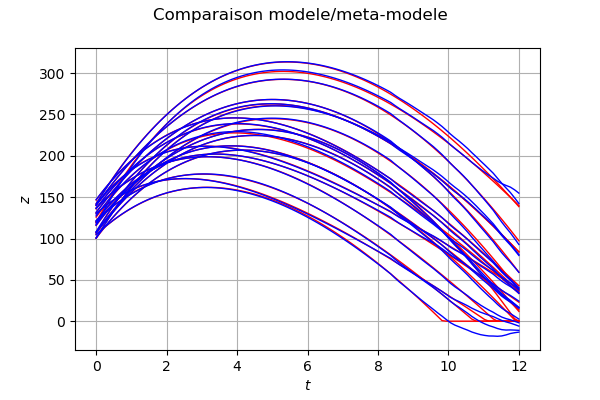

In [12]:
graph = validationOutputSample.drawMarginal(0)
graph.setColors(['red'])
graph2 = metaModel(validationInputSample).drawMarginal(0)
graph2.setColors(['blue'])
graph.add(graph2)
graph.setTitle('Comparaison modele/meta-modele')
graph.setXTitle(r'$t$')
graph.setYTitle(r'$z$')
graph